In [2]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

In [3]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

Before training we need data! For this notebook we will use the FashionMNIST dataset. Which is available in [torchvision](https://pytorch.org/vision/stable/index.html)


In [20]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

# Exercise 1

- What are the benefits of a dataloader?

Dataloader = se encarga de cargarlos datos. Es quién va sacando cosas de la caja. Los beneficios del dataloader son los siguientes:
  - comodidad de su uso y establecer num_workers (=cantidad de procesos usados por el dataloader para cargar los datos).
  - establecer shuffle (=cambiar o no el orden de los datos de training para que nuestro modelo no entrene con primero todos los vestidos, después con todas las camisetas, seguidamente con todos los pantalones, etc).
  - paraleliza la recogida de datos (mientras un proceso hace el forward, también recoge imágenes).

- Is there another transform that we can add to make the problem easier?


- How can we make the dataloaders defined above better? [docs](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

Podemos cambiar el brillo, el contraste y la saturación de las imágener para hacerlas más simples. Además, también podemos normalizar los datos.

Podemos también hacer un shuffle del train tal y como hemos comentado anteriormente.

In [22]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ColorJitter(
                                brightness=1.5, contrast=0, saturation=10),transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ColorJitter(
                                brightness=1.5, contrast=0, saturation=10),transforms.ToTensor(),transforms.Normalize(0.5,0.5)]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True, num_workers=0)

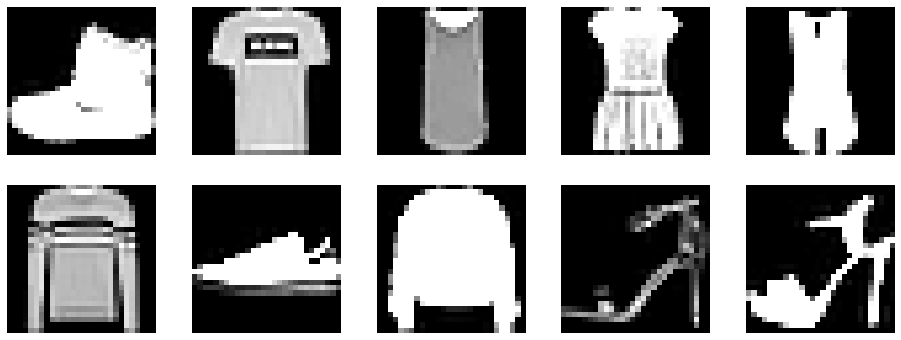

In [23]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

# Excersice 2

Modify your best performing architecture from last week and create a class model that can work for any input and output size (using the `__init__()` parameters)

## Fully connected model

In [33]:
class SimpleMLP(nn.Module):
    def __init__(self, inp_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.input_size = input_size
        self.pipe = nn.Sequential(
            nn.Linear(inp_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 75),
            nn.ReLU(),
            nn.Linear(75, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim), 
        ).to(device)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.pipe(x)



class FCModel(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [34]:
# Find more initializations here https://pytorch.org/docs/stable/nn.init.html?highlight=init
def initialize_parameters(model):   #inicializa los parámetros del modelo

    for name, w in model.named_parameters():
        if "weight" in name:
            torch.nn.init.ones_(w)
        
        if "bias" in name:
            torch.nn.init.zeros_(w)   

In [36]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = SimpleMLP(input_size, 128, output_size)   #per a canviar el model utilitzat

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

initialize_parameters(model)

Number of parameters 114465:


In [37]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

#Exercise 3

Notice in the above cell in line 54 notice the `.item()` when accumulating our loss. What would happen if we were to remove this `.item()`? 

Hint: it wont make a difference in the `validate()` function. 


`.item()` coge el valor guardado en el loss tensor.

Una función de pérdida, o Loss function, es una función que evalúa la desviación entre las predicciones realizadas por la red neuronal y los valores reales de las observaciones utilizadas durante el aprendizaje. Cuanto menor es el resultado de esta función, más eficiente es la red neuronal.

### Run Training

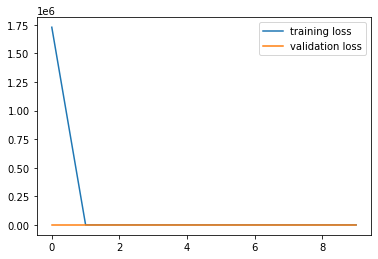

In [38]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

Tal i com podem veure en el gràfic, l'accuracy en aquest cas és pràcticament 0, per tant, el model no ha après res. A l'apartat següent veurem que això es deu a l'inicialització dels paràmetres. 

# Homework

A) Change the initialization for the model parameters (this will help a great deal) Explain in your own words why a bad initialization can be detrimental to  performance?

In [43]:
# Find more initializations here https://pytorch.org/docs/stable/nn.init.html?highlight=init
def initialize_parameters(model):   #inicializa los parámetros del modelo

    for name, w in model.named_parameters():
        if "weight" in name:
            torch.nn.init.kaiming_normal_(w, a=0, mode='fan_in', nonlinearity='leaky_relu')
        
        if "bias" in name:
            torch.nn.init.zeros_(w)   

In [44]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = SimpleMLP(input_size, 128, output_size)   #per a canviar el model utilitzat

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

initialize_parameters(model)

Number of parameters 114465:


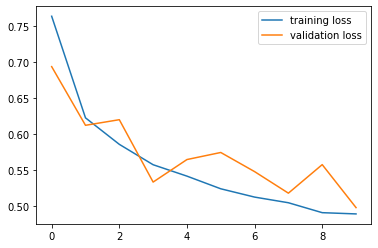

In [45]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

Anem a calcular la accuracy amb la inicialització que hem fet, però ja podem veure a simple vista que és molt millor que la inicialització anterior.

In [46]:
y_pred_list = []
total = 0
with torch.no_grad():
    model.eval()
    for X_batch, target_y in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        if target_y == y_pred_tags.item() : 
          total +=1
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print("Accuracy of {} with dataset_len {}".format(total/len(y_pred_list), len(y_pred_list)))

Accuracy of 0.821 with dataset_len 10000


Utilitzant la inicialització Kaiming Normal en els pesos, el model aprèn bé i aconsegueix una accuracy de 0.821, que és bastant bona. Una mala inicialització dels pesos pot portar a que el model s'encalli en mínims locals que no serveixen per a que el model aprengui (com a exemple tenim el gràfic de la primera inicialització).

B) Train the same model but with all of the pixels in each image permuted (permute all images in the same way), is the performance worse? If not why?

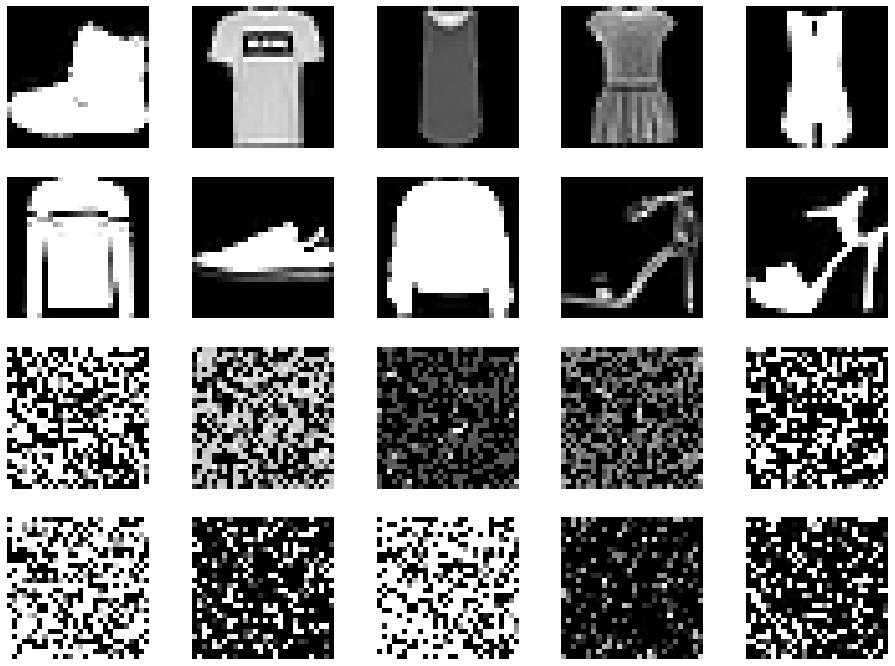

In [54]:
# Showing how to permute images
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), cmap="gray")
    plt.axis('off')

In [56]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))

#new_train_data = new_full(train_loader.dataset.shape, fill_value, dtype=None, device=None, requires_grad=False)
for i in range(len(train_loader.dataset.data)):
    image, _ = train_loader.dataset[i]
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    train_loader.dataset.data[i] = image_perm


<Figure size 1152x864 with 0 Axes>

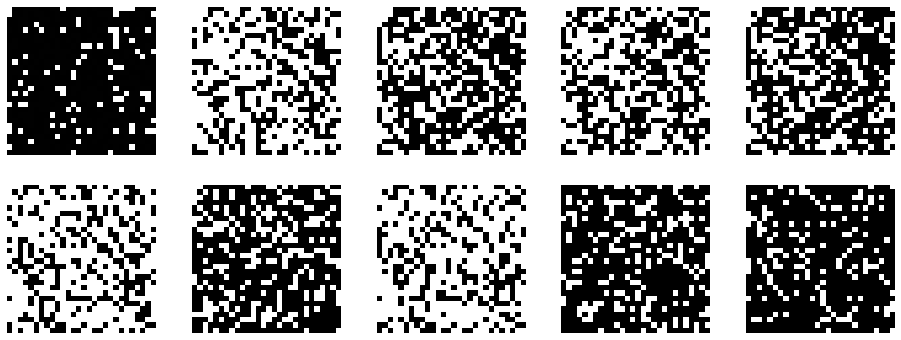

In [57]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i +1)
    image, _ = train_loader.dataset[i]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

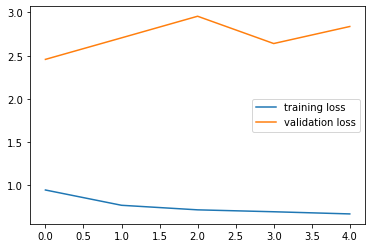

In [58]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = SimpleMLP(input_size, 128, output_size)

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

initialize_parameters(model)

losses = {"train": [], "val": []}
for epoch in range(5): #10

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show() 

In [59]:
#train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=0) #procesos que usa data loader para cargar datos
y_pred_list = []
total = 0
with torch.no_grad():
    model.eval()
    for X_batch, target_y in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        if target_y == y_pred_tags.item() : 
          total +=1
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print("Accuracy of {} with dataset_len {}".format(total/len(y_pred_list), len(y_pred_list)))

Accuracy of 0.1299 with dataset_len 10000


Si permutamos todos los píxeles de cada una de las imágenes siempre de la misma forma, es lógico que el resultado de las imágenes sean otras imágenes donde a simple vista no se pueda distinguir ninguna clase (camisa, pantalón, zapato).
En cambio, el modelo sí que debería aprender la forma en que están colocados los píxeles de las imágenes permutadas y asignar las imágenes que tengan una misma forma de una clase en concreto. Esto se debe a que el modelo es entrenado con las imágenes permutadas, y es validado también con estas imágenes permutadas [NOTAR DIFERENCIA ENTRE APARTADO B Y C]. Así pues, sé que tengo un resultado erróneo (accuracy de 0.1299), por lo que he hecho alguna cosa mal en este apartado que no sé identificar.

C) With a trained model. Make prediction on 10 images, then, horizontally flip the same images and predict again. Is the performance the same? Why?

La predicción de las imágenes normales ya se ha hecho anteriormente, dando una accuracy de 0.821.
Vamos a hacer la predicción de las imágenes giradas a continuación:

0


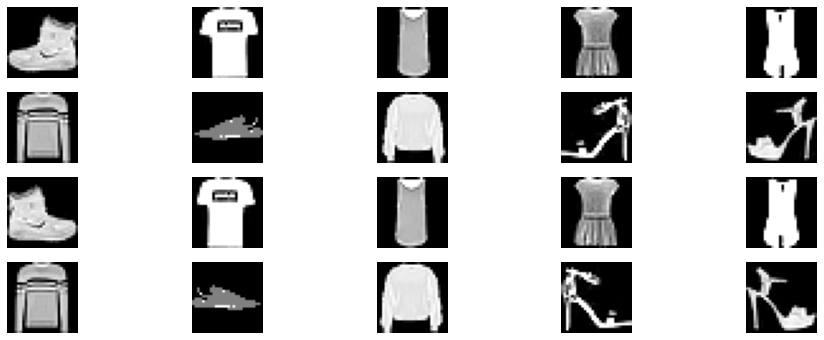

In [51]:
plt.figure(figsize=(16, 6))
total = 0
for i in range(10):
    image, _ = train_loader.dataset[i]
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

    im = torch.flip(image, [-3,2])
    plt.subplot(4, 5, i + 11)
    plt.imshow(im.squeeze().numpy(), cmap="gray")
    plt.axis('off');

print(total)

In [52]:
y_pred_list = []
total = 0
with torch.no_grad():
    model.eval()
    for X_batch, target_y in val_loader:
        im = torch.flip(X_batch, [-3,2])
        im = im.to(device)
        y_test_pred = model(im)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        if target_y == y_pred_tags.item() : 
          total +=1
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print("Accuracy of {} with dataset_len {}".format(total/len(y_pred_list), len(y_pred_list)))

Accuracy of 0.2298 with dataset_len 10000


Vemos que la accuracy cae en picado a 0.2298, por lo que el modelo no predice bien las imágenes giradas horizontalmente. Veo lógico esta disminución de accuracy, ya que es de esperar si tenemos en cuenta que el modelo ha sido entrenado con imágenes puestas de un lado, mientras que ha sido validad con las mismas imágenes pero giradas horizontalmente. El modelo no sabe qué está pasando y es por eso que 'no da ni una'.

D) Compare, using a confusion matrix, the performance of the MLP against a KNN classifier that takes as input:

*   The flattened image
*   The output of the MLP

No he sabido hacer este apartado.